# Site logo analysis

This notebook shows the seqlogo analysis based on the KL divergence 

## Set up the analysis

### Import the python modules

In [1]:
import os
import Bio.SeqIO
import dmslogo
import dmslogo.colorschemes
from IPython.display import display, HTML
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yaml
import logomaker as lm

### Read in data

In [2]:
site_color_schemes = pd.read_csv('../data/site_class.csv',index_col=0)

In [3]:
site_color_schemes["color"]=site_color_schemes["class"].map({"n":"#808080","1":"#044B7F","2":"#E3B505","3":"#610345","1+2":"#044B7F","4":"#107E7D"})
site_color_schemes=site_color_schemes.rename(columns={"site":"pos"})
site_color_schemes.head()

,pos,class,ACE2,color
1,445,3,None,#610345
2,345,3,None,#610345
3,443,3,None,#610345
4,500,3,#C640D7,#610345
5,446,3,#C640D7,#610345


In [4]:
synthetic_init=pd.read_csv('../data/init_seq_2022-01-01_0.8.csv',index_col=0)

In [5]:
synthetic=pd.read_csv('../result/gisaid_synthetic_score.csv',index_col=0)

In [6]:
with open('../data/Covid19_RBD_seq.txt','r') as f:
    wt_seq=f.read()
wt=[str(x)+str(y) for x,y in zip(list(wt_seq),list(range(331,532)))]
wt_dict=pd.DataFrame({"pos":list(range(331,532)),"wt":wt}).set_index("pos").to_dict()
wt_dict=wt_dict["wt"]

### utility functions

In [7]:
def generate_psedo_count_matrix(pcm_1, pcm_2, len_1, len_2, pseudo_count=0.01):
    # one thing we need to make sure is that the zero counts do not influence our results 
    # As we only focus on the true "mutational" change found by our model
    # so set different pseudo counts according to the size of the two datasets
    pcm_1 = pcm_1 + pseudo_count
    pcm_2 = pcm_2 + pseudo_count*len_2/len_1
    return pcm_1, pcm_2

def get_frequency_matrix(pcm_1, pcm_2):
    # for consistency and avoiding misleading, compute the frequency matrix only from count matrix 
    pfm_1 = pcm_1/np.sum(pcm_1, axis=1)[0]
    pfm_2 = pcm_2/np.sum(pcm_2, axis=1)[0]
    return pfm_1, pfm_2


def kl_logo_matrix(pfm_1, pfm_2, mode="prob_weight_KL"):
    log_pfm_2 = np.log(pfm_2)
    log_pfm_1 = np.log(pfm_1)
    if mode == "prob_weight_KL":
        KL_site = np.sum(pfm_2*np.log(pfm_2) - pfm_2*np.log(pfm_1), axis=1)
        site_norm = np.sum(pfm_2 * np.abs(np.log(pfm_2/pfm_1)), axis=1)[:, np.newaxis]
        kl_logo = KL_site[:, np.newaxis] * pfm_2 * np.log(pfm_2/pfm_1) / site_norm
        return kl_logo
    elif mode=="KL_site":
        KL_site = np.sum(pfm_2*np.log(pfm_2) - pfm_2*np.log(pfm_1), axis=1)
        return KL_site
    

In [8]:
def get_top_df (gisaid_attack,top_n,attack2_init,add):
    gisaid_attack=gisaid_attack.sort_values(by="mean_score",ascending=False)[:top_n]
    counts_mat_init=lm.alignment_to_matrix(attack2_init["seq"])
    counts_mat_attack=lm.alignment_to_matrix(gisaid_attack["seq"])
    counts_mat_init,counts_mat_attack=generate_psedo_count_matrix(counts_mat_init,counts_mat_attack,attack2_init.shape[0],gisaid_attack.shape[0],add)
    pfm_init,pfm_attack2=get_frequency_matrix(counts_mat_init,counts_mat_attack)
    KL=kl_logo_matrix(pfm_init,pfm_attack2,mode="prob_weight_KL")
    KL["pos"]=list(range(331,532))
    df=pd.melt(KL,id_vars="pos")
    df=pd.merge(df,site_color_schemes[["pos","color","ACE2"]],on="pos")
    df["wt_label"]=df.pos.map(wt_dict)
    df["shade_alpha"]=0.1
    df=df.rename(columns={"value":"prob_weight_KL"})
    return df

In [9]:
def save_figure(df,add,top,measure,KL_site,n):
    fig, ax = dmslogo.draw_logo(data=df[df["pos"].isin(KL_site.KL_site.sort_values(ascending=False)[:n].index)],
                        x_col='pos',
                        letter_col='variable',
                        letter_height_col=measure,
                        heatmap_overlays=["Relative Entropy"],
                        color_col="color",
                        xtick_col="wt_label",
                        xlabel="Site",
                        ylabel="Bits",
                        shade_color_col='ACE2',
                        shade_alpha_col='shade_alpha',
                        axisfontscale= 1.2,
                        letterheightscale=1,
                        # fontfamily="Arial"
                        )

    fig.savefig('figures/%s_%s_%s_seqlogo_add%s.png'%(str(n),"top"+str(top),measure,str(add)),bbox_inches='tight',dpi=500)

In [10]:
def get_KL_site(add,top,gisaid_attack,attack2_init):
    gisaid_attack=gisaid_attack.sort_values(by="mean_score",ascending=False)[:top]
    counts_mat_init=lm.alignment_to_matrix(attack2_init["seq"])
    counts_mat_attack=lm.alignment_to_matrix(gisaid_attack["seq"])
    counts_mat_init,counts_mat_attack=generate_psedo_count_matrix(counts_mat_init,counts_mat_attack,attack2_init.shape[0],gisaid_attack.shape[0],add)
    pfm_init,pfm_attack2=get_frequency_matrix(counts_mat_init,counts_mat_attack)
    KL_site=kl_logo_matrix(pfm_init,pfm_attack2,"KL_site")
    KL_site.index=KL_site.index+331
    return(KL_site)

## KL_site

In [11]:
## set the pseudo counts and the sequence number selected
add=0.1
top=synthetic.shape[0]

In [12]:
KL_site=get_KL_site(add,top,synthetic,synthetic_init)

In [13]:
KL_site=KL_site.to_frame(name="KL_site")

In [15]:
## get the dataframe contain all the information
df=get_top_df(synthetic,top,synthetic_init,add)

<ipython-input-7-66fa668cbbde>:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  site_norm = np.sum(pfm_2 * np.abs(np.log(pfm_2/pfm_1)), axis=1)[:, np.newaxis]
<ipython-input-7-66fa668cbbde>:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kl_logo = KL_site[:, np.newaxis] * pfm_2 * np.log(pfm_2/pfm_1) / site_norm


In [16]:
df=df.merge(KL_site,on="pos")

In [17]:
df.head()

,pos,variable,prob_weight_KL,color,ACE2,wt_label,shade_alpha,KL_site
0,331,A,4.017659e-05,#808080,None,N331,0.1,0.005722
1,331,C,7.479675e-05,#808080,None,N331,0.1,0.005722
2,331,D,1.146129e-05,#808080,None,N331,0.1,0.005722
3,331,E,3.715375e-20,#808080,None,N331,0.1,0.005722
4,331,F,9.388346e-05,#808080,None,N331,0.1,0.005722


In [18]:
map=dmslogo.colorschemes.ValueToColorMap(minvalue=df['KL_site'].min(),
                                            maxvalue=df['KL_site'].max()+0.1,
                                            cmap='Reds')

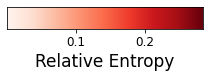

In [19]:
map_fig, _ = map.scale_bar(orientation='horizontal',
                             label='Relative Entropy')
display(map_fig)
#map_fig.savefig('figures/colorbar.png',bbox_inches='tight',dpi=96)
plt.close(map_fig)

In [20]:
df['Relative Entropy'] = map.val_to_color(df['KL_site'])

## seqlogo plot of top KL divergence

In [26]:
measure="prob_weight_KL"

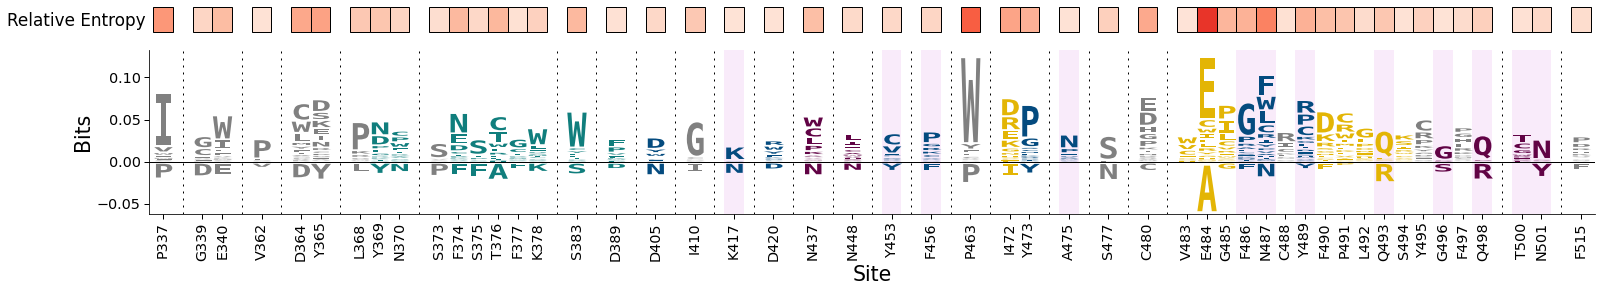

In [40]:
save_figure(df,add,top,measure,KL_site,50)

### seqlogo plot the whole RBD

In [42]:
import math
nsites = 201
sites_per_line=51
nlines=math.ceil(nsites/sites_per_line)
n_aa=20


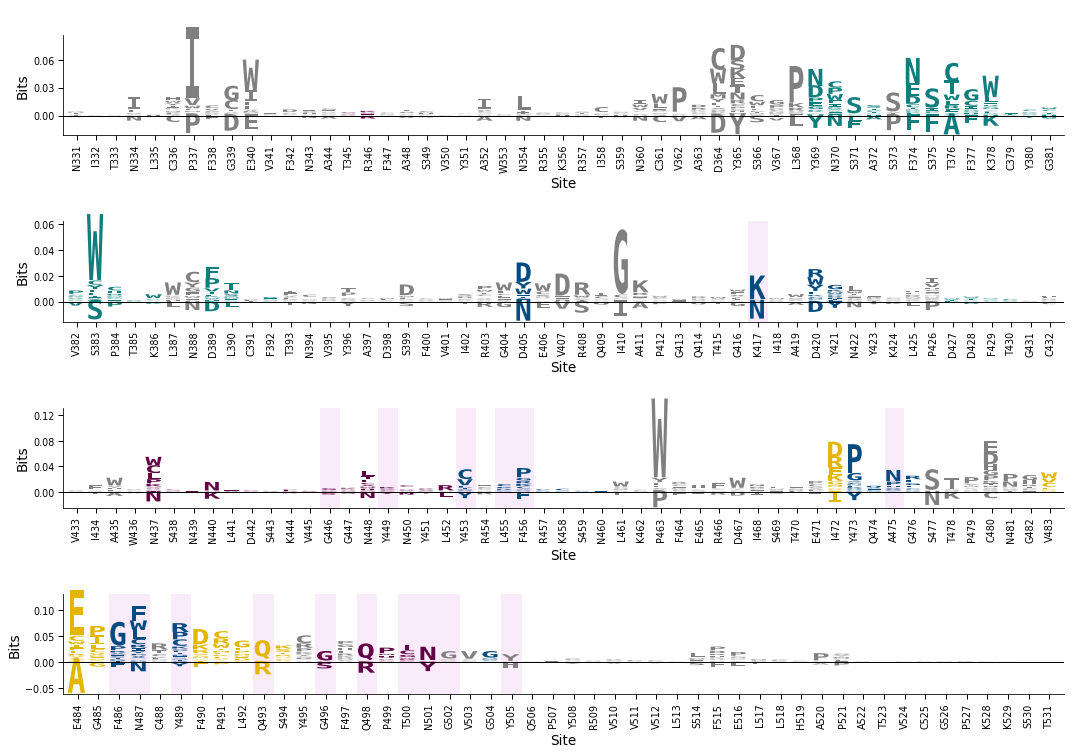

In [45]:
mode="KL_site"
scalewidth=1
scaleheight=1.5
fig = plt.figure(figsize=(scalewidth * sites_per_line * 0.3,
                              scaleheight * nlines * 1.75),
                     )
for iline in range(nlines):
    sub_df = df.iloc[iline * sites_per_line*n_aa: (iline + 1) * sites_per_line*n_aa]
    #ax=plt.subplot(nlines,1,iline+1)
    ax = plt.subplot2grid(shape=(nlines, sites_per_line),
                            loc=(iline, 0),
                            colspan=len(sub_df),  # number of sites for this line
                            fig=fig,
                            )
    dmslogo.draw_logo(data=sub_df,
                            x_col='pos',
                            letter_col='variable',
                            letter_height_col=measure,
                            #heatmap_overlays=["Relative Entropy"],
                            color_col="color",
                            xtick_col="wt_label",
                            xlabel="Site",
                            ylabel="Bits",
                            shade_color_col='ACE2',
                            shade_alpha_col='shade_alpha',
                            axisfontscale= 0.8,
                            letterheightscale=1,
                            ax=ax
                            )
fig.tight_layout()
plt.show()
fig.savefig('figures/All_site_%s_%s_%s_seqlogo_add%s.png'%(mode,"top"+str(top),measure,str(add)),bbox_inches='tight',dpi=500)

## Heatmap of pfm

In [46]:
counts_mat_init=lm.alignment_to_matrix(synthetic_init["seq"])
counts_mat_synthetic=lm.alignment_to_matrix(synthetic["seq"])
pfm_init,pfm_synthetic=get_frequency_matrix(counts_mat_init,counts_mat_synthetic)

In [47]:
pfm_init.index=pfm_init.index+331
pfm_synthetic.index=pfm_synthetic.index+331
# pfm_init=pfm_init.T
# pfm_attack2=pfm_attack2.T

In [48]:
import math
nsites = 201
sites_per_line=67
nlines=math.ceil(nsites/sites_per_line)
n_aa=20


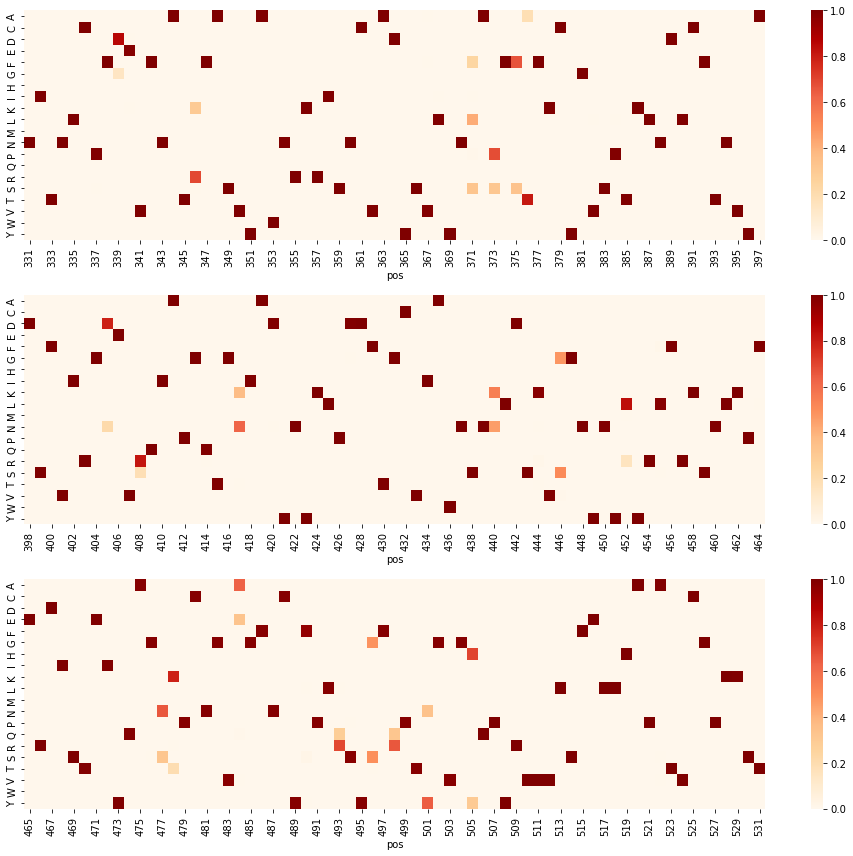

In [49]:
scalewidth=1
scaleheight=1
fig = plt.figure(figsize=(scalewidth * sites_per_line*0.2 ,
                              scaleheight * nlines *n_aa*0.2),
                     )
for iline in range(nlines):
    sub_df = pfm_init.iloc[iline * sites_per_line: (iline + 1) * sites_per_line]
    #ax=plt.subplot(nlines,1,iline+1)
    ax = plt.subplot2grid(shape=(nlines, sites_per_line),
                            loc=(iline, 0),
                            colspan=len(sub_df),  # number of sites for this line
                            fig=fig,
                            )
    sns.heatmap(sub_df.T,cmap="OrRd",vmin=0,vmax=1,yticklabels=True)
#plt.subplots_adjust(wspace=0.5)
fig.tight_layout()

#plt.savefig('figures/heatmap_pfm_init.png',dpi=500)
plt.show()

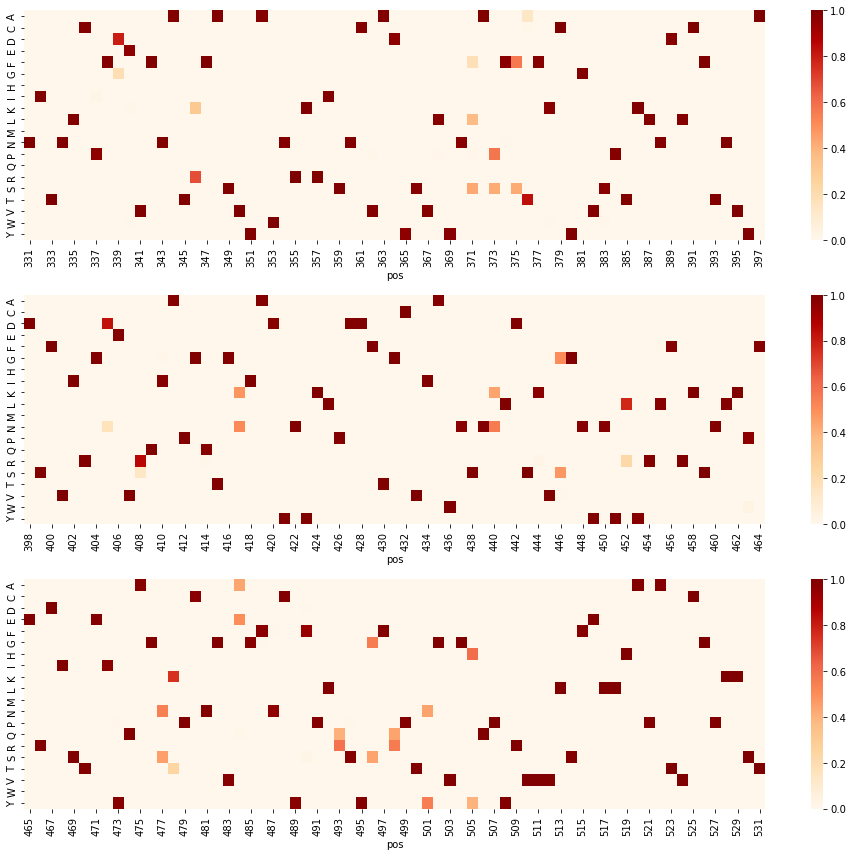

In [51]:
scalewidth=1
scaleheight=1
fig = plt.figure(figsize=(scalewidth * sites_per_line*0.2 ,
                              scaleheight * nlines *n_aa*0.2),
                     )
for iline in range(nlines):
    sub_df = pfm_synthetic.iloc[iline * sites_per_line: (iline + 1) * sites_per_line]
    #ax=plt.subplot(nlines,1,iline+1)
    ax = plt.subplot2grid(shape=(nlines, sites_per_line),
                            loc=(iline, 0),
                            colspan=len(sub_df),  # number of sites for this line
                            fig=fig,
                            )
    sns.heatmap(sub_df.T,cmap="OrRd",vmin=0,vmax=1,yticklabels=True)
#plt.subplots_adjust(wspace=0.5)
fig.tight_layout()

#plt.savefig('figures/heatmap_pfm_synthetic.png',dpi=500)
plt.show()